### Disclaimer

The following notebook was compiled for the course 'Geostatistics' at Ghent University (lecturer-in-charge: Prof. Dr. Ellen Van De Vijver; teaching assistant: Pablo De Weerdt). It consists primarily of notebook snippets created by Michael Pyrcz. The code and markdown (text) snippets were edited specifically for this course, using the 'Jura data set' (Goovaerts, 1997) as example in the practical classes. Some new code snippets are also included to cover topics which were not found in the Geostastpy package demo books.<br> 

This notebook is for educational purposes.<br> 

Guidelines for getting started were adapted from the 'Environmental Soil Sensing' course at Ghent University (lecturer-in-charge: Prof. Dr. Philippe De Smedt).<br> 

The Jura data set was taken from: Goovaerts P., 1997. Geostatistics for Natural Resources Evaluation. Oxford University Press.

**Don't forget to save a copy on your Google drive before starting !**

You can also 'mount' your Google Drive in Google colab to directly access your Drive folders (e.g., to access data and previous notebooks)

Do not hesitate to contact us for questions or feel free to ask questions during the practical sessions.

# Geostatistics: Introduction to geostatistical data analysis with Python

In [1]:
# Import required packages for setup
# -------------------------------------------- #

import sys
import os

In [ ]:
#  Clone the repository and add it to the path
if 'google.colab' in sys.modules:
    !git clone https://github.com/SENSE-UGent/E_I002454_Geostatistics.git
    sys.path.append('/content/E_I002454_Geostatistics') #Default location in Google Colab after cloning
else:
    # if you are not using Google Colab, change the path to the location of the repository
    sys.path.append(r'c:\Users\pdweerdt\Documents\Repos\E_I002454_Geostatistics')
    
# Import the setup function
from Utils.setup import check_and_install_packages

# Read the requirements.txt file
if 'google.colab' in sys.modules:
    requirements_path = '/content/E_I002454_Geostatistics/Utils/requirements.txt'
else:
    requirements_path = 'c:/Users/pdweerdt/Documents/Repos/E_I002454_Geostatistics/Utils/requirements.txt'

with open(requirements_path) as f:
    required_packages = f.read().splitlines()

# Check and install packages
check_and_install_packages(required_packages)

#### Load Required libraries

In [10]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))   # these notebooks were tested with GeostatsPy version: 0.0.72

GeostatsPy version: 0.0.72


We will also need some standard packages. These should have been installed when running the setup function before.

In [11]:
from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)
                                   
import numpy as np                                            # ndarrays for gridded data
                                       
import pandas as pd                                           # DataFrames for tabular data

import matplotlib.pyplot as plt                               # for plotting

from scipy import stats                                       # summary statistics

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression

import scipy.special

plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements

ignore_warnings = True                                        # ignore warnings?
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')

from IPython.utils import io                                  # mute output from simulation

seed = 42                                                     # random number seed

### Optional libraries

These are not required to run the given version of this practical exercise, but might be useful if you want to extend this notebook with more code.

In [13]:
from scipy.stats import pearsonr                              # Pearson product moment correlation
from scipy.stats import spearmanr                             # spearman rank correlation    
                                   
import seaborn as sns                                         # advanced plotting

import matplotlib as mpl                                        

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.colors import ListedColormap 
import matplotlib.ticker as mtick 
import matplotlib.gridspec as gridspec

### Set the Working Directory

Do this to simplify subsequent reads and writes (avoid including the full address each time). 

##### For use in Google Colab

Run the following cell if you automatically want to get the data from the repository and store it on your Google Colab drive.

In [ ]:
# change the working directory to the cloned repository

os.chdir('E_I002454_Geostatistics')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

##### For local use

Only run the following cell if you have the data locally stored.

In [ ]:
# set the working directory, place an r in front to address special characters
os.chdir(r'C:\\Users\\pdweerdt\\OneDrive - UGent\\I002454 - Geostatistics\\AY 2024-2025\\Practicals')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

Current Working Directory is  C:\Users\ervdevij\OneDrive - UGent\Onderwijs\2024-2025 Geostatistics\Ellen tests GeoStats\Practicals


### Loading Tabular & Gridded Data

Here's the section in which we will load our data file into a Pandas' DataFrame object.

Let's also load and visualize a grid!

Check the datatype of your gridded data.

In this case it is actually also a .dat file, so we can use the same function to import it. The .grid extension was given to indicate that it is gridded data.

In [15]:
# Here you can adjust the relative Path to the data folder

data_path = cd + '/Hard_data' 

In [16]:
file_name = '//prediction.dat'

df = GSLIB.GSLIB2Dataframe(data_path + file_name) # read the data

In [17]:
grid_file_name = '//rocktype.grid'

# load the data

df_grid = GSLIB.GSLIB2Dataframe(data_path + grid_file_name)

### Define feature of interest

In [18]:
feature = 'Co'
unit = 'ppm'

## Calculate some statistics

In P1 we calculated some statistics which we will use again in P2 to plot our data and perform an ANOVA.

In [19]:
min = round((df[feature].values).min(),2)                    # calculate the minimum
max = round((df[feature].values).max(),2)                    # calculate the maximum
mean = round((df[feature].values).mean(),2)                  # calculate the mean
stdev = round((df[feature].values).std(),2)                  # calculate the standard deviation
n = df[feature].values.size                                  # calculate the number of data


print('The minimum is ' + str(min) + ' ' + str(unit)+ '.') # print univariate statistics
print('The maximum is ' + str(max) + ' ' + str(unit)+ '.')
print('The mean is ' + str(mean) + ' ' + str(unit)+ '.')
print('The standard deviation is ' + str(stdev) + ' ' + str(unit) + '.')
print('The number of data is ' + str(n) + '.')

The minimum is 1.55 ppm.
The maximum is 17.72 ppm.
The mean is 9.3 ppm.
The standard deviation is 3.57 ppm.
The number of data is 259.


In P1 we already ran some code for plotting spatial data; this is always a good first step in spatial analysis.

## Plotting Spatial Data

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https:\/twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

Cite as: Pyrcz, M.J., 2024, Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy, https://geostatsguy.github.io/GeostatsPyDemos_Book. 

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This is a tutorial for / demonstration of **Visualizing Spatial Data** with GeostatsPy, including,

* **location maps** for plotting tabular spatial data, data points in space with one or more features
* **pixel plots** for plotting gridded, exhaustive spatial data and models with one or more features


####  Colorbar

Check the 
* [Matplotlib colormaps](https://matplotlib.org/stable/users/explain/colors/colormaps.html) for plotting with matplotlib
* [seaborn color palettes](https://seaborn.pydata.org/generated/seaborn.color_palette.html) for plotting with seaborn

In [20]:
cmap = plt.cm.inferno                                         # color map

#### Specify the Area of Interest / Grid and Feature Limits

Let's specify a reasonable extent for our grid and features:

* We do this so we have consistent plots for comparison. 

* We design a grid that balances detail and computation time. Note kriging computation complexity scales

* so if we half the cell size we have 4 times more grid cells in 2D, 4 times the runtime.

We could use commands like this one to find the minimum value of a feature:
```python
df[feature].min()
```
* But, it is natural to set the ranges manually, e.g., do you want your color bar to go from 0.05887 to 0.24230 exactly? 

In [21]:
xmin = 0; xmax = np.ceil(df.Xloc.max())                                   # range of x values
ymin = 0; ymax = np.ceil(df.Yloc.max())                                   # range of y values

In [ ]:
# get the dimensions of the grid
df_grid.shape

(6148, 3)

#### Visualizing Tabular Data with Location Maps

Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

Let's add the plotting parameters.

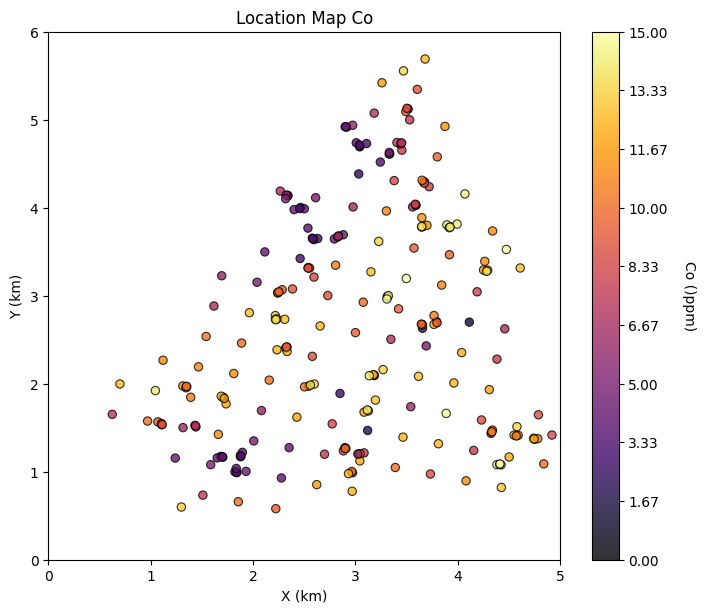

In [32]:
GSLIB.locmap_st(
                df, 'Xloc', 'Yloc', feature, xmin, xmax, ymin, ymax, 
                0, 15, # set the value range for the color map
                ('Location Map ' + str(feature)),'X (km)','Y (km)',
                (str(feature) + ' ()' + str(unit) + ')'), cmap
                )

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2); plt.show()

#### Grid

We can initialise a new column into our grid dataframe for the trend surface data. We start with a 1st order, linear surface, here called a 1st degree polynomial trend.

In [24]:
degree = 1

df_grid[feature + 'poly' + str(degree)] = -99999 # assign a dummy value to the new feature

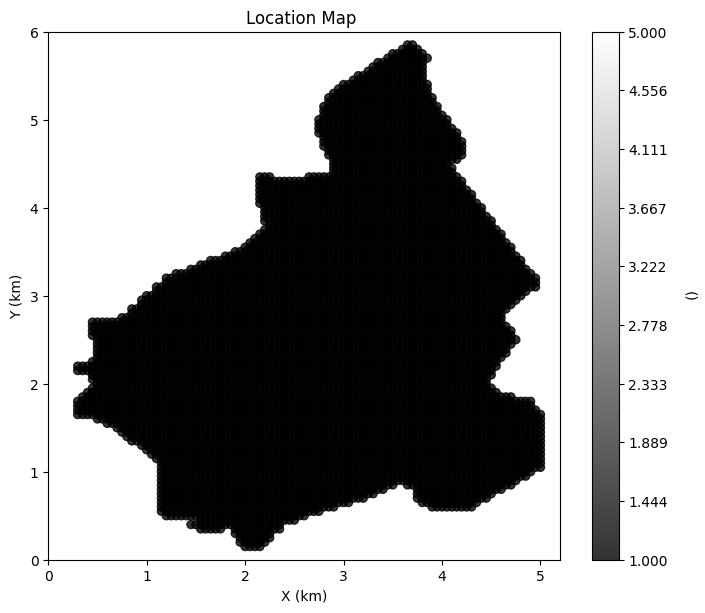

In [25]:
GSLIB.locmap_st(df_grid,'x', 'y', feature + 'poly' + str(degree),
                0, 5.2, ymin, ymax, 
                1, 5, # set the value range for the color map
                (
                    'Location Map ' 
               #   + str(grid_feature)
                 ), 
                 'X (km)', 'Y (km)',
             (
               #   str(grid_feature) + ' (' + str(unit) + ')'
                 ), 'gray')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2)

We can hardly differentiate the individual grid points but they are surely there! Also ignore the colobar in this case as we focus on the grid locations.

## Trend surfaces: Polynomial models

Code written for 'Geostatistics' course at Ghent University.

### Model fitting

In [26]:
# define x, y, and feature arrays for the trend surface fitting

coords = df[['Xloc','Yloc']].values
feature_values = df[feature].values

grid_coords = df_grid[['x','y']].values

In [27]:
# define our polynomial model, with whatever degree we want
degree=1

# PolynomialFeatures will create a new matrix consisting of all polynomial combinations 
# of the features with a degree less than or equal to the degree we just gave the model (2)
poly_model = PolynomialFeatures(degree=degree)

# transform out polynomial features
poly_coords = poly_model.fit_transform(coords)

# should be in the form [1, a, b, a^2, ab, b^2], this is without using the feature values!!
print(f'initial values {coords[0]}\nMapped to {poly_coords[0]}')

initial values [2.386 3.077]
Mapped to [1.    2.386 3.077]


In [ ]:
# let's fit the model, with the feature values
poly_model.fit(coords, feature_values)

# we use linear regression as a base!!! ** sometimes misunderstood **
regression_model = LinearRegression()

regression_model.fit(poly_coords, feature_values)

y_pred = regression_model.predict(poly_coords)

print(regression_model.intercept_)
print(regression_model.coef_[1:]) # skip the first term, which is 0

# Construct the polynomial equation
terms = poly_model.get_feature_names_out(['x', 'y'])
equation = f"{regression_model.intercept_:.3f} + " + " + ".join(
    f"{coef:.3f}*{term}" for coef, term in zip(regression_model.coef_[1:], terms[1:]) # skip the first term, which is 0
)
print(f"Polynomial Equation: {equation}\n")

7.15084559362883
[ 1.29180554 -0.63696561]
Polynomial Equation: 7.151 + 1.292*x + -0.637*y



This polynomial model can now be fitted onto our grid, and we can compare different polynomial degrees.

### Grid fitting & plotting

In [29]:
# grid fitting

number_degrees = [1,2,3]

for degree in number_degrees:

      # our feature
      poly_model = PolynomialFeatures(degree=degree)

      poly_coords = poly_model.fit_transform(coords)

      regression_model = LinearRegression()
      regression_model.fit(poly_coords, feature_values)

      poly_grid_coords = poly_model.fit_transform(grid_coords)
      df_grid[str(feature) + 'poly' + str(degree)] = regression_model.predict(poly_grid_coords)

      print(f"Degree {degree} Polynomial:")
      print(f"Intercept: {regression_model.intercept_}")
      print(f"Coefficients: {regression_model.coef_[1:]}") # skip the first term, which is 0

      # Construct the polynomial equation
      terms = poly_model.get_feature_names_out(['x', 'y'])
      equation = f"{regression_model.intercept_:.3f} + " + " + ".join(
            f"{coef:.3f}*{term}" for coef, term in zip(regression_model.coef_[1:], terms[1:]) # skip the first term, which is 0
      )
      print(f"Polynomial Equation: {equation}\n")

Degree 1 Polynomial:
Intercept: 7.15084559362883
Coefficients: [ 1.29180554 -0.63696561]
Polynomial Equation: 7.151 + 1.292*x + -0.637*y

Degree 2 Polynomial:
Intercept: 10.097182514176925
Coefficients: [-2.37499     0.71578381  0.45613383  0.51140187 -0.48962523]
Polynomial Equation: 10.097 + -2.375*x + 0.716*y + 0.456*x^2 + 0.511*x y + -0.490*y^2

Degree 3 Polynomial:
Intercept: -13.420933044618838
Coefficients: [ 3.09143324e+00  2.48888637e+01  2.18391714e+00 -7.99786727e+00
 -5.07747342e+00 -2.86224599e-01  1.99879516e-01  1.45838033e+00
 -2.16094298e-05]
Polynomial Equation: -13.421 + 3.091*x + 24.889*y + 2.184*x^2 + -7.998*x y + -5.077*y^2 + -0.286*x^3 + 0.200*x^2 y + 1.458*x y^2 + -0.000*y^3



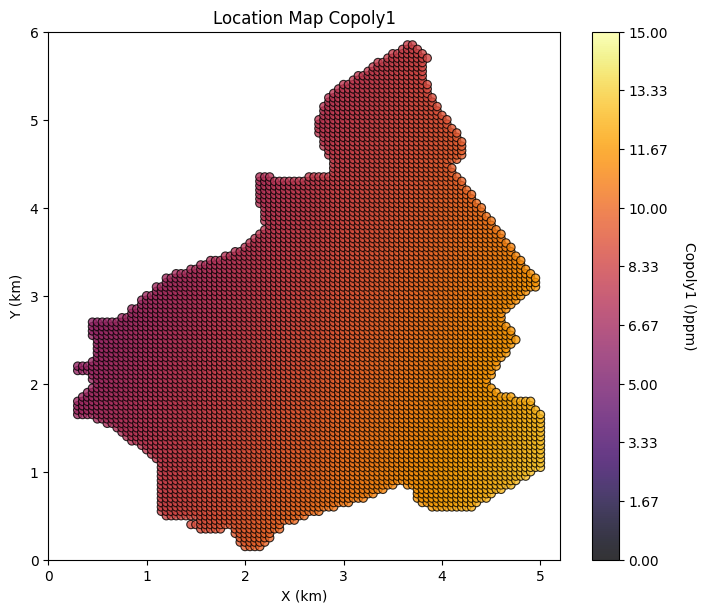

In [31]:
degree = 1  # set the degree of the polynomial

GSLIB.locmap_st(df_grid,'x', 'y', str(feature) + 'poly' + str(degree),
                0, 5.2, 
                ymin, ymax, 
                0, 15, # set the value range for the color map
                ('Location Map ' + str(str(feature) + 'poly' + str(degree))), 'X (km)', 'Y (km)',
             (str(str(feature) + 'poly' + str(degree)) + ' ()' + str(unit) + ')'), cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2)

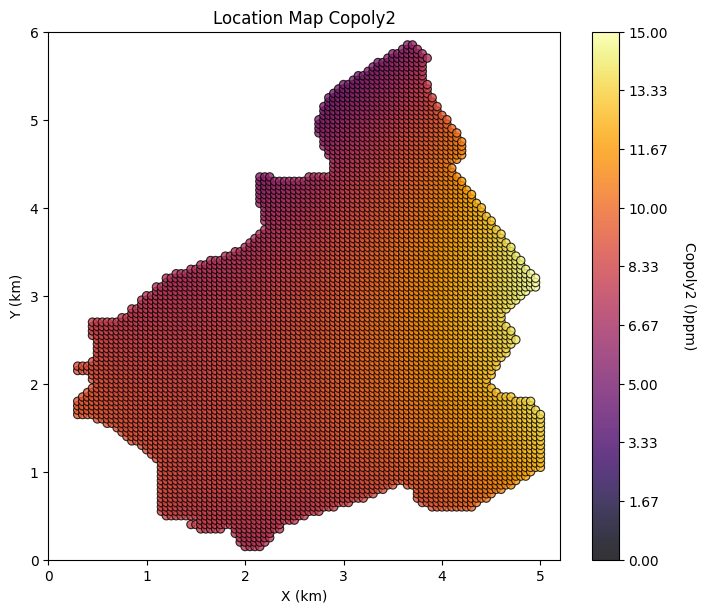

In [33]:
degree = 2  # set the degree of the polynomial

GSLIB.locmap_st(df_grid,'x', 'y', str(feature) + 'poly' + str(degree),
                0, 5.2, 
                ymin, ymax, 
                0, 15, # set the value range for the color map
                ('Location Map ' + str(str(feature) + 'poly' + str(degree))), 'X (km)', 'Y (km)',
             (str(str(feature) + 'poly' + str(degree)) + ' ()' + str(unit) + ')'), cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2)

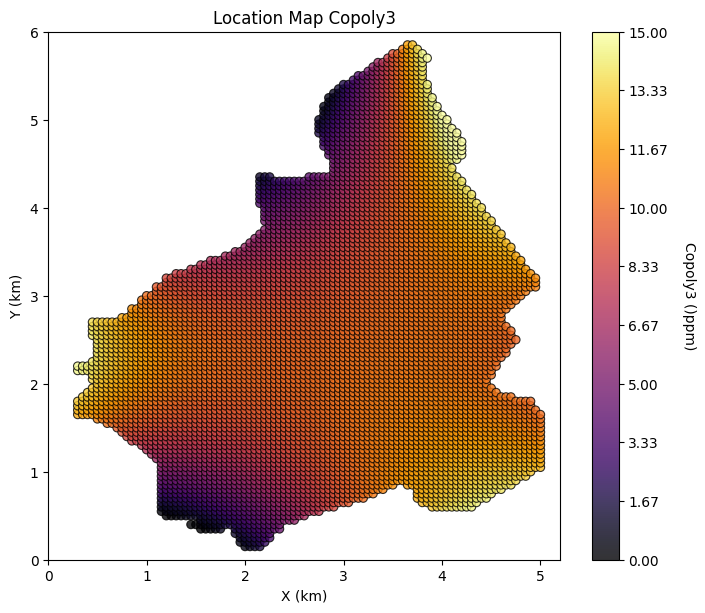

In [34]:
degree = 3  # set the degree of the polynomial

GSLIB.locmap_st(df_grid,'x', 'y', str(feature) + 'poly' + str(degree),
                0, 5.2, 
                ymin, ymax, 
                0, 15, # set the value range for the color map
                ('Location Map ' + str(str(feature) + 'poly' + str(degree))), 'X (km)', 'Y (km)',
             (str(str(feature) + 'poly' + str(degree)) + ' ()' + str(unit) + ')'), cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2)

### Exporting results

Resulting dataframes, figures can also be exported to your local Geostatistics folder (e.g., on your C: drive). These files can be opened in other software for further analysis.

#### For local saving

In [ ]:
#  Define the path where to export
export_path = 'C:\\Users\\pdweerdt\\OneDrive - UGent\\I002454 - Geostatistics\\AY 2024-2025\\Practicals\\Data\\Export'

#### For Google Drive saving

Mount Drive first to Google Colab

In [ ]:
# Mount Google Drive
from google.colab import drive # import the drive method for mounting Google Drive
drive.mount('/content/drive')

You will probably get a message to authorize mounting Google Drive on Colab.

Next up we can set the filte path in Google Drive, below is the general code for saving files on your Drive Parent folder, best is to save it into a subfolder for this course for example: <br> **'/content/drive/My Drive/Geostatistics/Export'**

In [ ]:
# Define the file path in Google Drive
export_path = '/content/drive/My Drive'

#### CSV

In [ ]:
#  export the grid to a csv file
df_grid.to_csv(export_path + '//grid_trends.csv', index=False)

print(f'DataFrame exported to {export_path}')

#### GSLIB format (.dat)

Required format if you want to open your results in SGeMS

In [ ]:
# export the grid to a GSLIB file
GSLIB.Dataframe2GSLIB(export_path + 
                      '//grid_trends.dat', #optional: change the name of the file here
                      df_grid )

### ANOVA

First, we will run the same fitting to get the results specifically at the locations of our observations (remember that this method is a non-exact predictor, so we will get different values from our trend fitting results).

In [35]:
# grid prediction

number_degrees = [1,2,3]

for degree in number_degrees:

      # for our feature
      poly_model = PolynomialFeatures(degree=degree)

      poly_x_coords = poly_model.fit_transform(coords)

      regression_model = LinearRegression()
      regression_model.fit(poly_x_coords, feature_values)

      poly_grid_coords = poly_model.fit_transform(coords)

      df[str(feature) + 'poly' + str(degree)] = regression_model.predict(poly_grid_coords)

      print(f"Degree {degree} Polynomial:")
      print(f"Intercept: {regression_model.intercept_}")
      print(f"Coefficients: {regression_model.coef_[1:]}")

      # Construct the polynomial equation
      terms = poly_model.get_feature_names_out(['x', 'y'])
      equation = f"{regression_model.intercept_:.3f} + " + " + ".join(
            f"{coef:.3f}*{term}" for coef, term in zip(regression_model.coef_[1:], terms[1:]) # skip the first term, which is 0
      )
      print(f"Polynomial Equation: {equation}\n")

Degree 1 Polynomial:
Intercept: 7.15084559362883
Coefficients: [ 1.29180554 -0.63696561]
Polynomial Equation: 7.151 + 1.292*x + -0.637*y

Degree 2 Polynomial:
Intercept: 10.097182514176925
Coefficients: [-2.37499     0.71578381  0.45613383  0.51140187 -0.48962523]
Polynomial Equation: 10.097 + -2.375*x + 0.716*y + 0.456*x^2 + 0.511*x y + -0.490*y^2

Degree 3 Polynomial:
Intercept: -13.420933044618838
Coefficients: [ 3.09143324e+00  2.48888637e+01  2.18391714e+00 -7.99786727e+00
 -5.07747342e+00 -2.86224599e-01  1.99879516e-01  1.45838033e+00
 -2.16094298e-05]
Polynomial Equation: -13.421 + 3.091*x + 24.889*y + 2.184*x^2 + -7.998*x y + -5.077*y^2 + -0.286*x^3 + 0.200*x^2 y + 1.458*x y^2 + -0.000*y^3



In [ ]:
# ANOVA
degrees = [1, 2, 3]

anova_results = []

for degree in degrees:
    print(f"{feature} poly {degree} ANOVA")
    print(f"polynomial {degree}")

    # Create ANOVA backbone table
    data = [['Trend', '', '', '', '', '', '', ''], ['Deviation', '', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '', '']]
    anova_table = pd.DataFrame(data, columns=['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit', 'R_sq (%)'])
    anova_table.set_index('Source of Variation', inplace=True)

    n_data = df.shape[0]

    mean = df[feature].mean()

    n_variables = 2
    n_terms = scipy.special.binom(n_variables + degree, degree)  # includes intercept

    # Calculate SSr and update ANOVA table
    SSr = sum((df[f"{feature}poly{degree}"] - mean) ** 2)
    anova_table.at['Trend', 'SS'] = SSr

    # Calculate SSt and update ANOVA table
    SSt = sum((df[feature] - mean) ** 2)
    anova_table.at['Total', 'SS'] = SSt

    # Calculate SSd and update ANOVA table
    SSd = SSt - SSr
    anova_table.at['Deviation', 'SS'] = SSd

    # Update degree of freedom
    anova_table.at['Trend', 'df'] = n_terms - 1
    anova_table.at['Deviation', 'df'] = n_data - n_terms
    anova_table.at['Total', 'df'] = n_data - 1

    # Calculate MS
    anova_table['MS'] = anova_table['SS'] / anova_table['df']

    # Calculate F
    F = anova_table.at['Trend', 'MS'] / anova_table.at['Deviation', 'MS']
    anova_table.at['Trend', 'F'] = F

    # P-value
    anova_table.at['Trend', 'P-value'] = 1 - stats.f.cdf(F, anova_table.at['Trend', 'df'], anova_table.at['Deviation', 'df'])

    # F critical
    alpha = 0.05
    # Possible types "right-tailed, left-tailed, two-tailed"
    tail_hypothesis_type = "two-tailed"
    if tail_hypothesis_type == "two-tailed":
        alpha /= 2
    anova_table.at['Trend', 'F crit'] = stats.f.ppf(1 - alpha, anova_table.at['Trend', 'df'], anova_table.at['Deviation', 'df'])

    # R-squared
    anova_table.at['Trend', 'R_sq (%)'] = SSr / SSt * 100

    # Add degree information
    anova_table['Degree'] = degree

    # Append the ANOVA table to the results list
    anova_results.append(anova_table)

# Concatenate all ANOVA tables into a single DataFrame
final_anova_df = pd.concat(anova_results)

# Final ANOVA Table
print(final_anova_df)

Co poly 1 ANOVA
polynomial 1
Co poly 2 ANOVA
polynomial 2
Co poly 3 ANOVA
polynomial 3
                              SS     df          MS          F P-value  \
Source of Variation                                                      
Trend                 478.672638    2.0  239.336319  21.721909     0.0   
Deviation            2820.658967  256.0   11.018199                      
Total                3299.331605    258   12.788107                      
Trend                 693.502998    5.0    138.7006  13.466447     0.0   
Deviation            2605.828607  253.0   10.299718                      
Total                3299.331605    258   12.788107                      
Trend                1266.812902    9.0  140.756989  17.243871     0.0   
Deviation            2032.518703  249.0    8.162726                      
Total                3299.331605    258   12.788107                      

                       F crit   R_sq (%)  Degree  
Source of Variation                            

### Significance on increase in order

We could also define a function for these ANOVA tests,  here's an example to test significance of icnrease in order

In [37]:
# Function to Calculate significance of the increase in order from degree 1 to 2 and 2 to 3
def calculate_significance(anova_df, degrees):
    
    significance_results = []

    for i in range(1, len(degrees)):
        degree_current = degrees[i]
        degree_previous = degrees[i - 1]

        # Extract SS and df for current and previous degrees
        SSr_current = anova_df.loc[(anova_df['Degree'] == degree_current) & (anova_df.index == 'Trend'), 'SS'].values[0]
        SSr_previous = anova_df.loc[(anova_df['Degree'] == degree_previous) & (anova_df.index == 'Trend'), 'SS'].values[0]

        df_current = anova_df.loc[(anova_df['Degree'] == degree_current) & (anova_df.index == 'Trend'), 'df'].values[0]
        df_previous = anova_df.loc[(anova_df['Degree'] == degree_previous) & (anova_df.index == 'Trend'), 'df'].values[0]

        # Calculate the increase in SS and df
        SS_increase = SSr_current - SSr_previous
        df_increase = df_current - df_previous

        # Extract MS for deviation for the current degree
        MS_deviation_current = anova_df.loc[(anova_df['Degree'] == degree_current) & (anova_df.index == 'Deviation'), 'MS'].values[0]

        # Calculate F-statistic
        F_increase = (SS_increase / df_increase) / MS_deviation_current

        # Calculate p-value
        p_value = 1 - stats.f.cdf(F_increase, df_increase, df_current)

        # Append results
        significance_results.append({
            'From Degree': degree_previous,
            'To Degree': degree_current,
            'SS Increase': SS_increase,
            'df Increase': df_increase,
            'F Increase': F_increase,
            'p-value': p_value
        })

    return pd.DataFrame(significance_results)

In [ ]:
# Calculate and display the significance results
degrees = [1, 2, 3]

significance_df = calculate_significance(final_anova_df, degrees)
print(significance_df)

   From Degree  To Degree  SS Increase  df Increase  F Increase   p-value
0            1          2   214.830360          3.0    6.952629  0.031087
1            2          3   573.309904          4.0   17.558776  0.000280
